In [2]:
# import os
# import re

# for file in os.listdir('../checkpoints'):
#     os.rename('../checkpoints/' + file, '../checkpoints/' + re.sub(r'(.+)_\d+\.(.+)', r'\1.\2', file))
#     print(file)
#     print(re.sub(r'(.+)_\d+\.(.+)', r'\1.\2', file))
#     print('---')

## Load Pre-trained

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import json
import numpy as np
import scanpy as sc
import time
import copy
from scipy.sparse import issparse

from utils import set_seed, AttrDict
from vocab import Vocab
from preprocess import Preprocessor, get_interactions, get_z
from tokenizer import Tokenizer, random_mask_value
from model import TransformerModel, BioFormerModel
from loss import masked_mse_loss, masked_relative_error, criterion_neg_log_bernoulli

checkpoint = 'bioformer-af2-8'

PATH = '../checkpoints/' + checkpoint
config = AttrDict(json.load(open(PATH + '.json')))
print(config)

# if config.seed:
#     set_seed(config.seed)

# Import data
path_to_transcriptional_interactions = '../data/transcriptional_interactions.csv'
dataset_name = config.dataset_name

if dataset_name == 'BREAST_25K':
    adata = sc.read_h5ad('../data/breast_25k.h5ad')
    data_is_raw = True

elif dataset_name == 'BREAST_12K':
    adata = sc.read_h5ad('../data/breast_12k.h5ad')
    data_is_raw = True

elif dataset_name == 'DERMAL_100K':
    adata = sc.read_h5ad('../data/dermal_100k.h5ad')
    adata.var["gene_name"] = adata.var.feature_name.tolist()
    data_is_raw = True

elif dataset_name == 'HYPOXIA_9K':
    adata = sc.read_h5ad('../data/scsHypoxiaTimeSub.h5ad')
    adata.X = adata.layers['raw_count']
    adata.var['gene_name'] = adata.var.index.tolist()
    data_is_raw = True

print(dataset_name)
print(adata)

# Pre-process RNA-seq data
preprocessor = Preprocessor(use_key="X",  # the key in adata.layers to use as raw data
                            filter_gene_by_counts=3,  # step 1
                            filter_cell_by_counts=False,  # step 2
                            normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
                            result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
                            log1p=data_is_raw,  # 4. whether to log1p the normalized data
                            result_log1p_key="X_log1p",
                            subset_hvg=config.n_hvg,  # 5. whether to subset the raw data to highly variable genes
                            hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
                            binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
                            result_binned_key="X_binned",  # the key in adata.layers to store the binned data
                            )
preprocessor(adata, batch_key=None)

# Vocab
genes = adata.var["gene_name"].tolist()
vocab = Vocab(genes)
vocab.set_default_index(vocab["<pad>"]) # index to return if token not found in vocab
print(f'Init vocab of size {len(vocab)} with {config.n_hvg} unique genes...')
print(f"CLS in vocab: {vocab.stoi['<cls>']}")

# Tokenize & Pad
tokenizer = Tokenizer(vocab = vocab,
                      append_cls = True,
                      cls_token = "<cls>",
                      pad_token = "<pad>",
                      pad_value = -2,
                      include_zero_gene= config.include_zero_gene, 
                      )
tokenized = tokenizer.tokenize_and_pad_batch(adata.layers["X_binned"].toarray() if issparse(adata.layers["X_binned"]) else adata.layers["X_binned"],
                                             np.array(vocab(genes), dtype=int),
                                             max_len=config.n_hvg + 1,
                                             )
print(f"Tot samples: {tokenized['genes'].shape[0]}")
print(f"Input length: {tokenized['genes'].shape[1]}")

# Max memory required per intermediate step:
if config.model == 'BioFormer':
        # no. elements in the [B, r, r, c, c] opm intermediate matrix
        tmp = config.batch_size * (config.n_hvg + 1) ** 2 * config.d_opm ** 2
        
        # number of bytes required (using np.float32)
        tmp = tmp * 4

        print(f'memory required for opm: {tmp/1e6 :,.2f}MB')
        

# RNA-seq Dataset
class SeqDataset(Dataset):
    """
    Create RNA-seq dataset from vocabulary with keys ['gene_ids', 'valeus', 'target_vaules', 'interactions'].
    """
    def __init__(self, data: dict):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

# Mask and get interactions
def prepare_data():
    """
    1. Random mask the data
    2. Get the interaction matrix z
    3. Convert to torch.Dataset.
    
    """
    masked_values = random_mask_value(tokenized["values"])
    print(f"Random masking at epoch {epoch}...")

    B, r = masked_values.shape
    if config.init_z:
        tf = get_interactions(genes, path_to_transcriptional_interactions)
    interactions = get_z(tokenized["genes"], tf, vocab.itos) if config.init_z else torch.zeros((B, r, r))    # [B, r, r]

    data_pt = {
        "gene_ids": tokenized["genes"],           # [B, r]
        "values": masked_values,                  # [B, r]
        "target_values": tokenized["values"],     # [B, r]
        "interactions": interactions              # [B, r, r]
    }

    return SeqDataset(data_pt)

# --------------------------------------------------------------------------- #
# ------------------------------ TEST MODEL --------------------------------- #
# --------------------------------------------------------------------------- #                                         )

criterion = masked_mse_loss

epoch_start_time = time.time()

epoch = 0
dataset = prepare_data()

loader = DataLoader(
    dataset=dataset,
    batch_size=config.batch_size,
    shuffle=True,
)

total_loss = 0.0
total_mre = 0.0
total_num = 0


{'run_name': 'bioformer-af2-8', 'dataset_name': 'HYPOXIA_9K', 'model': 'BioFormer', 'd_model': 256, 'nhead': 8, 'nlayers': 8, 'n_hvg': 255, 'do_pair_bias': True, 'do_opm': True, 'd_z': 128, 'd_opm': 32, 'init_z': False, 'do_train': True, 'epochs': 5, 'batch_size': 16, 'wandb': True, 'seed': 5289, 'n_bins': 51, 'include_zero_gene': False, 'explicit_zero_prob': True, 'log_interval': 100, 'lr': 0.001, 'amp': True, 'schedule_ratio': 0.1, 'save_model': '../checkpoints/'}
HYPOXIA_9K
AnnData object with n_obs × n_vars = 9234 × 19046
    obs: 'nCount_RNA', 'nFeature_RNA', 'SampleTags', 'percent.mt', 'HypoxicState', 'TimePoint', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'SampleTagsShort', 'active_ident'
    var: 'variable_gene', 'gene_name'
    uns: 'active_ident_colors', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'raw_count'
Filtering genes by counts ...
Normalizing total counts ...
Log1p transforming ...
Subsetting highly variable 

In [15]:
checkpoint = 'scgpt-256-8-256'
checkpoint = 'bioformer-af2-8-breast'

PATH = '../checkpoints/' + checkpoint
config = AttrDict(json.load(open(PATH + '.json')))
print(config)

# Instantiate model
if config.model == "scGPT":
    model = TransformerModel(ntoken=len(vocab),
                             d_model=config.d_model,
                             nhead=config.nhead,
                             nlayers=config.nlayers,
                             pad_id = vocab.stoi['<pad>'],
                             explicit_zero_prob=config.explicit_zero_prob
                             ) 
    state_dict = torch.load(PATH + '.pt', weights_only=True, map_location=torch.device('cpu'))
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)

elif config.model == "BioFormer":
    model = BioFormerModel(ntoken=len(vocab),
                           d_model=config.d_model,
                           d_z = config.d_z,
                           d_opm = config.d_opm,
                           nhead=config.nhead,
                           nlayers=config.nlayers,
                           do_pair_bias=config.do_pair_bias,
                           do_opm=config.do_opm,
                           pad_id = vocab.stoi['<pad>'],
                           explicit_zero_prob=config.explicit_zero_prob
                           ) 
    state_dict = torch.load(PATH + '.pt', weights_only=True, map_location=torch.device('cpu'))
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)

# print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Parameters count
n_params = sum(p.numel() for p in model.parameters())
model_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
print(f'''device: {device} | model: {checkpoint} | d_model: {config.d_model} | nhead: {config.nhead} | nlayers: {config.nlayers} | tot. params: {n_params/1e6:.2f}M | model size: {model_size_bytes/1e6:.2f}MB''')



{'run_name': 'bioformer-af2-8-breast', 'dataset_name': 'BREAST_25K', 'model': 'BioFormer', 'd_model': 256, 'nhead': 8, 'nlayers': 8, 'n_hvg': 255, 'do_pair_bias': True, 'do_opm': True, 'd_z': 128, 'd_opm': 32, 'init_z': False, 'do_train': True, 'epochs': 5, 'batch_size': 16, 'wandb': True, 'seed': 5289, 'n_bins': 51, 'include_zero_gene': False, 'explicit_zero_prob': True, 'log_interval': 100, 'lr': 0.001, 'amp': True, 'schedule_ratio': 0.1, 'save_model': '../checkpoints/'}
device: cuda | model: bioformer-af2-8-breast | d_model: 256 | nhead: 8 | nlayers: 8 | tot. params: 6.09M | model size: 24.35MB


In [27]:
from model import BioFormerBlock
bioformer_block = BioFormerBlock(
                c_m=256,
                c_z=128,
                c_opm=32,
                no_heads=8,
                do_opm=True,
                do_pair_bias=True,
)
# bioformer_block = model.bioformer.blocks[0]
layer = bioformer_block.attn
print(layer)
print(f'--> no. params = {sum(p.numel() for p in layer.parameters()):,}')
print('\n' + '-'*89 + '\n')

RowAttentionWithPairBias(
  (layer_norm_m): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_norm_z): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (linear_z): Linear(in_features=128, out_features=8, bias=False)
  (linear_q): Linear(in_features=256, out_features=32, bias=False)
  (linear_k): Linear(in_features=256, out_features=32, bias=False)
  (linear_v): Linear(in_features=256, out_features=32, bias=False)
  (linear_o): Linear(in_features=32, out_features=256, bias=True)
)
--> no. params = 34,816

-----------------------------------------------------------------------------------------



In [9]:
# batch_data = next(iter(loader))
batch_size = 2
ixs = torch.randint(0, len(dataset), (batch_size,)).tolist()
batch_data = dataset[ixs]

input_gene_ids = batch_data["gene_ids"].to(device)
input_values = batch_data["values"].to(device)
target_values = batch_data["target_values"].to(device)
if config.model == "BioFormer":
    interactions = batch_data['interactions'].to(device)
    output = model(input_gene_ids, input_values, interactions, return_z = True)
    z = output['z'][0].detach().cpu().numpy()
else:
    output = model(input_gene_ids, input_values)

# msk = ~target_values.eq(-2) & ~target_values.eq(0)
msk = input_values.eq(-1)

# compute MSE
loss = criterion(output['mlm_output'], target_values, msk)
print('-'*20)
print(f'loss: {loss.item():.2f}')
print('-'*20)
for i in range(output['mlm_output'][msk].shape[0]):
    print(f"true: {target_values[msk][i]:4} | pred: {output['mlm_output'][msk][i]:.1f}")

--------------------
loss: 221.13
--------------------
true: 24.0 | pred: 28.7
true: 46.0 | pred: 31.2
true: 25.0 | pred: 23.1
true: 38.0 | pred: 24.7
true: 37.0 | pred: 21.1
true: 35.0 | pred: 21.0
true:  9.0 | pred: 40.1
true: 31.0 | pred: 23.5
true: 25.0 | pred: 26.3
true: 27.0 | pred: 21.9
true: 27.0 | pred: 35.0
true: 41.0 | pred: 21.5
true: 19.0 | pred: 20.5
true: 23.0 | pred: 24.8
true: 11.0 | pred: 23.2
true: 43.0 | pred: 36.3
true: 24.0 | pred: 25.3
true: 43.0 | pred: 20.7
true: 10.0 | pred: 39.0
true: 27.0 | pred: 15.6
true: 46.0 | pred: 23.7
true: 38.0 | pred: 24.6
true:  8.0 | pred: 22.7
true: 39.0 | pred: 22.4
true: 42.0 | pred: 16.2
true: 32.0 | pred: 24.8
true: 32.0 | pred: 25.2


Extract the processed Z and try to visualize it

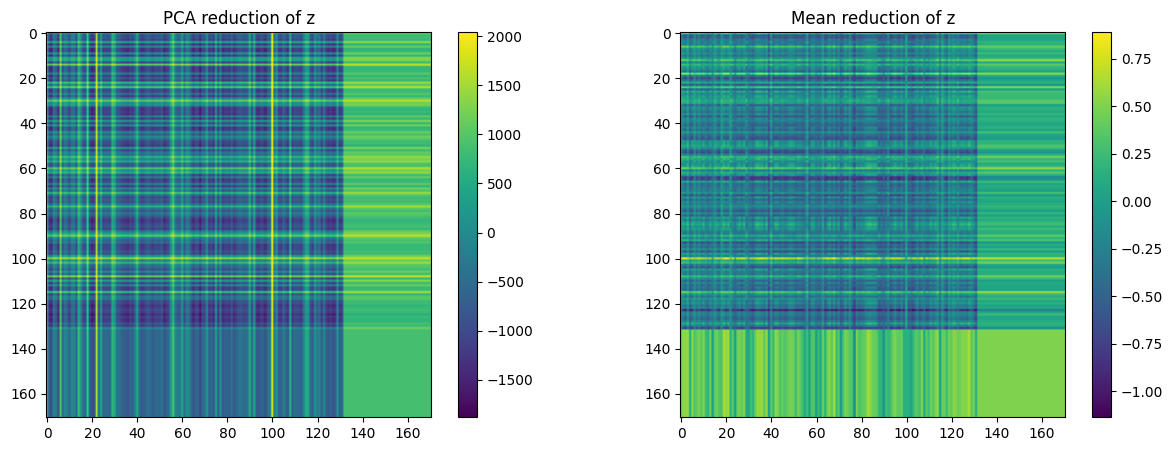

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

R, _, C = z.shape
z_reshaped = z.reshape(-1, C)  # Flatten to (R*R, C)

pca = PCA(n_components=1)
z_reduced = pca.fit_transform(z_reshaped)  # Reduces to (R*R, 1)

S_pca = z_reduced.reshape(R, R)  # Reshape back to (R, R)


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('PCA reduction of z')
plt.imshow(S_pca)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Mean reduction of z')
plt.imshow(z.mean(-1))
plt.colorbar()
plt.show()

Inspect the PCA.  

Get the genes such that the mean of their row is above the 95% percentile

In [ ]:
np.quantile(S_pca, 0.95)
pca_outliers = np.arange(R)[S_pca.mean(axis=0) > np.quantile(S_pca.mean(axis=0), 0.95)]             # Get rows with all values > 1000
pca_outliers_gene_ids = input_gene_ids.cpu()[0, pca_outliers].tolist()                              # gene_ids correspoding to row above
vocab.lookup_tokens(pca_outliers_gene_ids)                                                          # gene names

['ANKRD37', 'CEMIP', 'COL1A2', 'RASD1']